# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pkl

## Loading the data

In [2]:
def load_ICM_data(path):
    ICM_data = {}
    for file in os.listdir(os.fsencode(path)):
        filename = os.fsdecode(file)
        df = pd.read_csv(path + filename, index_col='id')
        ICM_data[filename[:-4]] = df
    return ICM_data

In [3]:
icm_data = load_ICM_data("data/InCognitoMatchData_SM/")
icm_data.keys()

dict_keys(['experiments', 'exp_instance', 'exp_pairs', 'exp_results', 'exp_schema', 'exp_users', 'riddles'])

## Setting the data for the project

### Set it up

In [4]:
results = icm_data['exp_results']
pairs = icm_data['exp_pairs']
riddles = icm_data['riddles']

In [5]:
data = pd.merge(results, pairs, how='left', on=['exp_id', 'sch_id_1', 'sch_id_2']) # Merge results and pairs
data = data[data['exp_id'].isin([14,15])] # Leave 14 15 exps only
data = data[['user_id', 'sch_id_1', 'sch_id_2', 'realconf', 'user_sub_val', 'userconf', 'alg', 'score', 'order', 'token_path', 'term_match', 'word_net']]
# Leave relevant columbns only 
data = data[(data['sch_id_1']!=0)&(data['sch_id_2']!=0)] # Remove 0 sch_id_1 - not necessarily good
del data['alg'], data['score'] # delete non-relevant columns
data.loc[data['sch_id_1'] >= 215, ['sch_id_1', 'sch_id_2']] -= 94 # Adjust the sch_id indices

In [6]:
print(data.shape)
data.head(3)

(7131, 10)


,user_id,sch_id_1,sch_id_2,realconf,user_sub_val,userconf,order,token_path,term_match,word_net
0,171,134,180,0,67,34,1,0.484821,0.619156,1.0
1,171,134,182,0,69,38,2,0.454945,0.578095,1.0
2,171,153,183,1,38,24,3,0.552425,0.397624,1.0


### Is `order` has a 1:1 mapping to `(sch_id_1, sch_id_2)`?

If so, we will use it later on instead of the sch_id pair

In [7]:
t = data[['sch_id_1', 'sch_id_2', 'order']]
grouped_t = t.groupby(['sch_id_1', 'sch_id_2']).agg(lambda x: len(x.unique()))
display(grouped_t.head(2))
(grouped_t['order'] == 1).all()

,,order
sch_id_1,sch_id_2,
121,175,1
122,206,1


True

In [8]:
len(grouped_t)

30

There are 30 `sch_id` pairs, and each one is assosiated to exactly 1 `order`.

It remains to check the other way mapping.

In [9]:
grouped_t = t.groupby(['sch_id_1', 'sch_id_2']).agg(lambda x: x.unique()[0])
display(grouped_t.head(2))
grouped_t['order'].unique().size

,,order
sch_id_1,sch_id_2,
121,175,8
122,206,29


30

There are 30 unique `order`s, and so each order has it unique pair, and its a 1:1 mapping.

### Is the number of rows make sense?

In [10]:
unique_users = data['user_id'].unique().size
print(f"Unique users: {unique_users}")
unique_users * 30

Unique users: 309


9270

We are sure we have missing records, yet we dont know how many exactly, because we may have duplicates.

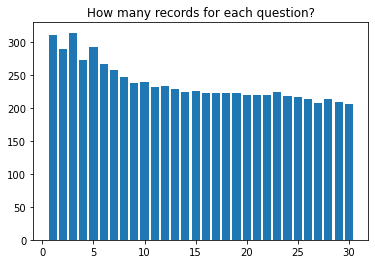

In [11]:
questions_counts = data['order'].value_counts().sort_index()
plt.bar(questions_counts.index, questions_counts)
plt.title("How many records for each question?")
plt.show()

In [12]:
(questions_counts > unique_users).sum()

2

Duplicates: for example, there are 2 questions recorded more than the number of unique users!

### Lets characterize duplicates

We would like each user and order to have at most 1 answer

In [13]:
answers_counts = data[['user_id', 'order']].groupby(['user_id', 'order']).size()
answers_counts[answers_counts > 1]

user_id  order
186      12        2
203      29        2
226      27        2
273      5         2
         10        2
         19        2
328      25        2
332      10        2
         20        2
346      6         3
388      1         3
398      24        3
406      13        3
410      7         2
419      3        11
428      7         2
         10        2
         22        2
         25        2
         28        2
433      3        19
437      23        6
480      28        3
489      10        2
499      3         5
504      15        2
505      19        2
         28        2
524      5        23
541      8         2
550      12        5
551      1         2
         28        2
558      6         2
         12        2
565      7         2
567      9         2
605      2         2
687      14        2
691      10        2
700      11        2
dtype: int64

First of all, what the fuck?

Secondly, lets check it out

In [14]:
data[(data['user_id']==186)&(data['order']==12)]

,user_id,sch_id_1,sch_id_2,realconf,user_sub_val,userconf,order,token_path,term_match,word_net
156,186,166,181,0,0,100,12,0.430476,0.427287,1.0
157,186,166,181,0,0,100,12,0.430476,0.427287,1.0


In [15]:
data[(data['user_id']==433)&(data['order']==3)]

,user_id,sch_id_1,sch_id_2,realconf,user_sub_val,userconf,order,token_path,term_match,word_net
3164,433,153,183,1,66,32,3,0.552425,0.397624,1.0
3165,433,153,183,1,66,32,3,0.552425,0.397624,1.0
3166,433,153,183,1,66,32,3,0.552425,0.397624,1.0
3167,433,153,183,1,62,24,3,0.552425,0.397624,1.0
3168,433,153,183,1,62,24,3,0.552425,0.397624,1.0
3169,433,153,183,1,62,24,3,0.552425,0.397624,1.0
3170,433,153,183,1,62,24,3,0.552425,0.397624,1.0
3171,433,153,183,1,62,24,3,0.552425,0.397624,1.0
3172,433,153,183,1,62,24,3,0.552425,0.397624,1.0
3173,433,153,183,1,62,24,3,0.552425,0.397624,1.0


Just the same!

Lets make sure all the cases are that way

In [16]:
total = True
for (user_id, order), amount in answers_counts[answers_counts > 1].iteritems():
    respective_df = data[(data['user_id']==user_id)&(data['order']==order)]
    all_the_same = (respective_df.nunique() == 1).all()
    total &= all_the_same
total

C:\Users\matan_39ey9fy\AppData\Local\Temp\ipykernel_8008\3740184355.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (user_id, order), amount in answers_counts[answers_counts > 1].iteritems():


False

Crap!

In [17]:
problematic = []
for (user_id, order), amount in answers_counts[answers_counts > 1].iteritems():
    respective_df = data[(data['user_id']==user_id)&(data['order']==order)]
    all_the_same = (respective_df.nunique() == 1).all()
    if not all_the_same:
        problematic.append((user_id, order))
problematic

C:\Users\matan_39ey9fy\AppData\Local\Temp\ipykernel_8008\2262144008.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (user_id, order), amount in answers_counts[answers_counts > 1].iteritems():


[(226, 27), (332, 20), (388, 1), (419, 3), (433, 3), (524, 5)]

In [18]:
(user_id, order) = problematic[5]
respective_df = data[(data['user_id']==user_id)&(data['order']==order)]
all_the_same = (respective_df.nunique() == 1).all()
display(respective_df.nunique() == 1)
respective_df

user_id          True
sch_id_1         True
sch_id_2         True
realconf         True
user_sub_val    False
userconf        False
order            True
token_path       True
term_match       True
word_net         True
dtype: bool

,user_id,sch_id_1,sch_id_2,realconf,user_sub_val,userconf,order,token_path,term_match,word_net
4416,524,163,176,1,90,80,5,0.570769,0.65,1.0
4417,524,163,176,1,87,74,5,0.570769,0.65,1.0
4418,524,163,176,1,87,74,5,0.570769,0.65,1.0
4419,524,163,176,1,87,74,5,0.570769,0.65,1.0
4420,524,163,176,1,91,82,5,0.570769,0.65,1.0
4421,524,163,176,1,91,82,5,0.570769,0.65,1.0
4422,524,163,176,1,91,82,5,0.570769,0.65,1.0
4423,524,163,176,1,91,82,5,0.570769,0.65,1.0
4424,524,163,176,1,95,90,5,0.570769,0.65,1.0
4425,524,163,176,1,95,90,5,0.570769,0.65,1.0


To conclude, we have users and question that has several DIFFERENT records.

In my opinion, it is probably because the system sent too many reports before the final answer, and the required thing to do is to take the last one.

That would also work for the other, equal, duplicates.

But, to achieve that we also need the times...

Then, if we leave the times for later use, lets also leave the sch_id_(1,2) = 0, as its the start time!

So, lets start over :)

## Start over

### set it up

In [19]:
data = pd.merge(results, pairs, how='left', on=['exp_id', 'sch_id_1', 'sch_id_2']) # Merge results and pairs
data = data[data['exp_id'].isin([14,15])] # Leave 14 15 exps only
data = data[['user_id', 'exp_id', 'sch_id_1', 'sch_id_2', 'realconf', 'rec_time', 'user_sub_val', 'userconf', 'alg', 'score', 'order', 'token_path', 'term_match', 'word_net']]
# Leave relevant columbns only 
del data['alg'], data['score'] # delete non-relevant columns
data.loc[data['sch_id_1'] >= 215, ['sch_id_1', 'sch_id_2']] -= 94 # Adjust the sch_id indices
data['rec_time'] = pd.to_datetime(data['rec_time'])

### Is `order` has a 1:1 mapping to `(sch_id_1, sch_id_2)`? (YES)

If so, we will use it later on instead of the sch_id pair

In [20]:
t = data[['sch_id_1', 'sch_id_2', 'order']]
grouped_t = t.groupby(['sch_id_1', 'sch_id_2']).agg(lambda x: len(x.unique()))
display(grouped_t.head(2))
(grouped_t['order'] == 1).all()

,,order
sch_id_1,sch_id_2,
0,0,1
121,175,1


True

In [21]:
len(grouped_t)

31

There are 31 `sch_id` pairs, and each one is assosiated to exactly 1 `order`.

It remains to check the other way mapping.

In [22]:
grouped_t = t.groupby(['sch_id_1', 'sch_id_2']).agg(lambda x: x.unique()[0])
display(grouped_t.head(2))
grouped_t['order'].unique().size

,,order
sch_id_1,sch_id_2,
0,0,0
121,175,8


31

There are 31 unique `order`s, and so each order has it unique pair, and its a 1:1 mapping.

### Is the number of rows make sense? 
OR: WTF is happening with the amount of users?!!!!!!

In [23]:
unique_users = data['user_id'].unique().size
print(f"Unique users: {unique_users}")
unique_users * 31

Unique users: 342


10602

<span style="color:red">Note that the number of unique users really increased because of the addition of the 0 question! What is goint on?</span>

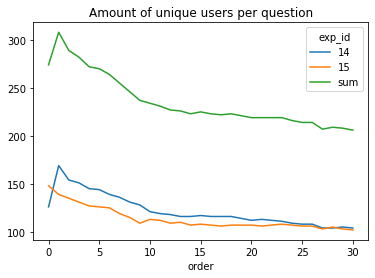

In [24]:
unique_users = data[['order', 'user_id', 'exp_id']].groupby(['order', 'exp_id']) \
                                                    .nunique() \
                                                    .reset_index() \
                                                    .pivot(index='order', columns='exp_id', values='user_id')
unique_users['sum'] = unique_users[14] + unique_users[15]
unique_users.plot()
plt.title("Amount of unique users per question")
plt.show()

The users are leaving the experiment!!! Nooooooooooooooooooooooooooooooooo!!!

Let's see what happen if we stay only with the users that are there for the whole experiment ("The loyal users")

In [25]:
set_of_loyal_users = set.intersection(*[set(data[data['order']==o]['user_id'].unique()) for o in range(1,31)])
len(set_of_loyal_users)

181

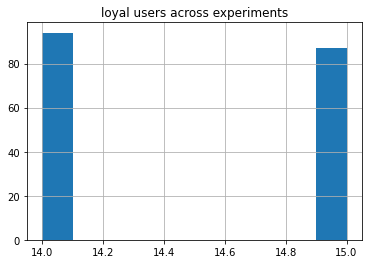

In [26]:
data[['user_id', 'exp_id']][data['user_id'].isin(set_of_loyal_users)].groupby('user_id').mean().hist()
plt.title('loyal users across experiments')
plt.show()

Ok, so we want to leave only the loyal users.

Note that we have much fewer loyal users if we take into account question 0, which we use only for time consideration.

Yet, these users have time records in the riddles table (I omitted this test).

So, we would like to omit the 0-question, and take the times from the riddles table.

So, lets start over (again) :|

## Start over (again)

### set it up

Initial

In [27]:
data = pd.merge(results, pairs, how='left', on=['exp_id', 'sch_id_1', 'sch_id_2']) # Merge results and pairs
data = data[data['exp_id'].isin([14,15])] # Leave 14 15 exps only
data = data[['user_id', 'exp_id', 'sch_id_1', 'sch_id_2', 'realconf', 'rec_time', 'user_sub_val', 'userconf', 'order', 'token_path', 'term_match', 'word_net']]
# Leave relevant columbns only
data = data[(data['sch_id_1']!=0)&(data['sch_id_2']!=0)] # Remove 0 sch_id
data.loc[data['sch_id_1'] >= 215, ['sch_id_1', 'sch_id_2']] -= 94 # Adjust the sch_id indices
data['rec_time'] = pd.to_datetime(data['rec_time'])

Second

In [28]:
data = data[data['user_id'].isin(set_of_loyal_users)].reset_index(drop=True)

In [29]:
zero_times = riddles[riddles['user_id'].isin(set_of_loyal_users)][['user_id', 'time']]

index = list(range(len(data), len(data)+len(set_of_loyal_users)))
columns = data.columns
new_df = pd.DataFrame(index=index, columns=columns)
new_df['user_id'] = zero_times['user_id'].values
new_df['rec_time'] = zero_times['time'].values
new_df['sch_id_1'], new_df['sch_id_2'], new_df['order'] = 0, 0, 0

user_exp = data[['user_id', 'exp_id']].groupby('user_id').mean()
new_df['exp_id'] = pd.merge(new_df, user_exp, how='left', left_on='user_id', right_index=True)['exp_id_y'].astype(int)

data = pd.concat([data, new_df]).sort_values(by=['user_id', 'order']).reset_index(drop=True)
data['rec_time'] = pd.to_datetime(data['rec_time'])

Final

In [30]:
print(data.shape)
data.head(3)

(5611, 12)


,user_id,exp_id,sch_id_1,sch_id_2,realconf,rec_time,user_sub_val,userconf,order,token_path,term_match,word_net
0,171,14,0,0,NaN,2020-12-19 12:28:13,NaN,NaN,0,NaN,NaN,NaN
1,171,14,134,180,0,2020-12-19 12:28:39,67,34,1,0.484821,0.619156,1.0
2,171,14,134,182,0,2020-12-19 12:28:45,69,38,2,0.454945,0.578095,1.0


### Is `order` has a 1:1 mapping to `(sch_id_1, sch_id_2)`? (YES)

If so, we will use it later on instead of the sch_id pair

In [31]:
t = data[['sch_id_1', 'sch_id_2', 'order']]
grouped_t = t.groupby(['sch_id_1', 'sch_id_2']).agg(lambda x: len(x.unique()))
display(grouped_t.head(2))
(grouped_t['order'] == 1).all()

,,order
sch_id_1,sch_id_2,
0,0,1
121,175,1


True

In [32]:
len(grouped_t)

31

There are 31 `sch_id` pairs, and each one is assosiated to exactly 1 `order`.

It remains to check the other way mapping.

In [33]:
grouped_t = t.groupby(['sch_id_1', 'sch_id_2']).agg(lambda x: x.unique()[0])
display(grouped_t.head(2))
grouped_t['order'].unique().size

,,order
sch_id_1,sch_id_2,
0,0,0
121,175,8


31

There are 31 unique `order`s, and so each order has it unique pair, and its a 1:1 mapping.

### WTF is happening with the amount of users?

In [34]:
unique_users = data['user_id'].unique().size
print(f"Unique users: {unique_users}")
unique_users * 31

Unique users: 181


5611

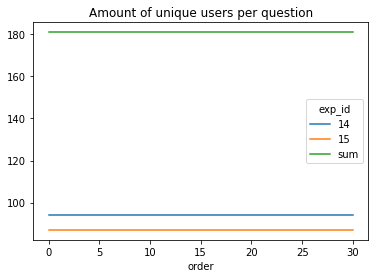

In [35]:
unique_users = data[['order', 'user_id', 'exp_id']].groupby(['order', 'exp_id']) \
                                                    .nunique() \
                                                    .reset_index() \
                                                    .pivot(index='order', columns='exp_id', values='user_id')
unique_users['sum'] = unique_users[14] + unique_users[15]
unique_users.plot()
plt.title("Amount of unique users per question")
plt.show()

Now it's fine :)

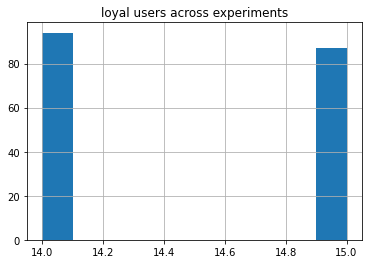

In [36]:
data[['user_id', 'exp_id']][data['user_id'].isin(set_of_loyal_users)].groupby('user_id').mean().hist()
plt.title('loyal users across experiments')
plt.show()

### Is the number of rows make sense?

In [37]:
unique_users = data['user_id'].unique().size
print(f"Unique users: {unique_users}")
unique_users * 31

Unique users: 181


5611

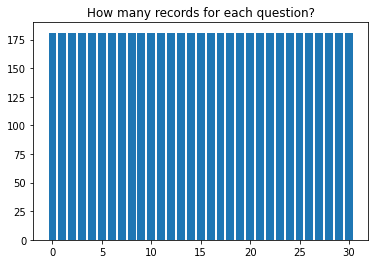

In [38]:
questions_counts = data['order'].value_counts().sort_index()
plt.bar(questions_counts.index, questions_counts)
plt.title("How many records for each question?")
plt.show()

In [39]:
(questions_counts > unique_users).sum()

0

It makes sense! But what happened to the duplicated problem we had before??

In [40]:
problematic_answers_counts = answers_counts[answers_counts>1]
problematic_answers_counts = set(problematic_answers_counts.index.get_level_values(0).unique())
len(set.intersection(problematic_answers_counts, set_of_loyal_users))

0

It appears to be that the intersection between the problematic users that causes the duplicates to the loyal users is empty!

All of the loyal users aren't problematic!! loyal indeed!

### Summary

In [41]:
data

,user_id,exp_id,sch_id_1,sch_id_2,realconf,rec_time,user_sub_val,userconf,order,token_path,term_match,word_net
0,171,14,0,0,NaN,2020-12-19 12:28:13,NaN,NaN,0,NaN,NaN,NaN
1,171,14,134,180,0,2020-12-19 12:28:39,67,34,1,0.484821,0.619156,1.000000
2,171,14,134,182,0,2020-12-19 12:28:45,69,38,2,0.454945,0.578095,1.000000
3,171,14,153,183,1,2020-12-19 12:28:54,38,24,3,0.552425,0.397624,1.000000
4,171,14,149,180,0,2020-12-19 12:28:57,57,14,4,0.502679,0.619156,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5606,711,14,164,178,1,2021-11-08 11:01:41,61,22,26,0.550549,0.493333,0.536885
5607,711,14,154,212,0,2021-11-08 11:01:43,89,78,27,0.294607,0.000000,0.113996
5608,711,14,152,182,1,2021-11-08 11:01:44,37,26,28,0.534670,0.500000,0.000000
5609,711,14,122,206,1,2021-11-08 11:01:46,76,52,29,0.270769,0.130476,0.072077


In [42]:
assert len(data) == 31 * data['user_id'].nunique()
print("All good")

All good


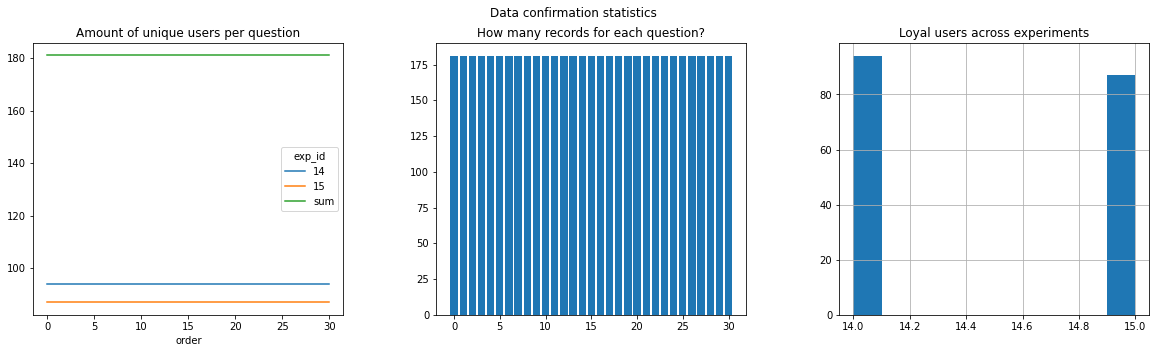

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
ax = axes[0]

unique_users = data[['order', 'user_id', 'exp_id']].groupby(['order', 'exp_id']) \
                                                    .nunique() \
                                                    .reset_index() \
                                                    .pivot(index='order', columns='exp_id', values='user_id')
unique_users['sum'] = unique_users[14] + unique_users[15]
unique_users.plot(ax=ax)
ax.set_title("Amount of unique users per question")

ax = axes[1]
questions_counts = data['order'].value_counts().sort_index()
ax.bar(questions_counts.index, questions_counts)
ax.set_title("How many records for each question?")

ax = axes[2]
data[['user_id', 'exp_id']][data['user_id'].isin(set_of_loyal_users)].groupby('user_id').mean().hist(ax=ax)
ax.set_title('Loyal users across experiments')

plt.suptitle("Data confirmation statistics")
plt.show()

In [67]:
t_data = data.drop(columns=['exp_id', 'sch_id_1', 'sch_id_2', 'user_sub_val'])
t_data['order-1'] = t_data['order'] - 1
t_data = pd.merge(left=t_data, right=t_data[['user_id', 'order', 'rec_time', 'userconf']],
         left_on=['user_id', 'order-1'], right_on=['user_id', 'order'],
         how='left')
t_data = t_data.rename(columns={'rec_time_x':'rec_time', 'userconf_x':'Y', 'order_x':'index', 'rec_time_y':'p_rec_time', 'userconf_y':'p_userconf'})
t_data = t_data.drop(columns=['order-1', 'order_y'])
t_data['time'] = (t_data['rec_time'] - t_data['p_rec_time']).dt.total_seconds()
t_data['T'] = (t_data['p_userconf'] == 100).astype(int)
# t_data = t_data[['user_id', 'index', 'realconf', 'time', 'token_path','term_match','word_net','T','Y']]
t_data = t_data[['user_id', 'index', 'time', 'token_path','term_match','word_net','T','Y']]
t_data.head(3)

,user_id,index,time,token_path,term_match,word_net,T,Y
0,171,0,NaN,NaN,NaN,NaN,0,NaN
1,171,1,26.0,0.484821,0.619156,1.0,0,34
2,171,2,6.0,0.454945,0.578095,1.0,0,38


In [68]:
mean_confidences = t_data[t_data['index']<=10][['user_id', 'Y']].groupby('user_id').mean()
mean_confidences = mean_confidences.rename(columns={'Y':'confidence'})
mean_confidences.head(2)

,confidence
user_id,
171,33.6
174,45.4


In [69]:
t_data1 = pd.merge(left=t_data, right=mean_confidences, left_on='user_id', right_index=True, how='left')
t_data1 = t_data1[['confidence'] + list(t_data1.columns[1:-1])]
t_data1 = t_data1[t_data1['index']>10]
t_data1 = t_data1.reset_index(drop=True)
t_data1

,confidence,index,time,token_path,term_match,word_net,T,Y
0,33.6,11,4.0,0.614881,1.000000,1.000000,0,18
1,33.6,12,3.0,0.430476,0.427287,1.000000,0,12
2,33.6,13,4.0,0.405652,0.672727,0.536469,0,10
3,33.6,14,1.0,0.707143,0.512222,0.533026,0,14
4,33.6,15,2.0,0.388095,0.387363,1.000000,0,20
...,...,...,...,...,...,...,...,...
3615,47.2,26,1.0,0.550549,0.493333,0.536885,0,22
3616,47.2,27,2.0,0.294607,0.000000,0.113996,0,78
3617,47.2,28,1.0,0.534670,0.500000,0.000000,0,26
3618,47.2,29,2.0,0.270769,0.130476,0.072077,0,52


In [70]:
save = True
if save:
    pkl.dump(t_data1, open("data/data.pkl", "wb"))

## Users

In [48]:
users = icm_data['exp_users']
loyal_users = users[users.index.isin(set_of_loyal_users)]
loyal_users = loyal_users.reset_index(names='user_id')

prolific_data = pd.read_csv("data/prolific_export_sm.csv")
t = prolific_data.groupby('participant_id').size()
display(prolific_data[prolific_data['participant_id'].isin(t[t!=1].index)])

prolific_data.drop([290, 483], axis=0, inplace=True)

,session_id,participant_id,status,started_datetime,completed_date_time,time_taken,age,num_approvals,num_rejections,prolific_score,reviewed_at_datetime,entered_code,Country of Birth,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status
73,609c01624fdf7f996f1637ca,5ec37264194de71cb7b82637,APPROVED,25:06.4,32:42.4,456.088,19.0,299,0,100,16:24.7,20E7C955,Canada,Canada,Part-Time,English,China,Female,Yes
99,609c142a645068ccd7b89beb,60705ec072fce615131f89aa,APPROVED,45:20.2,57:54.8,754.593,40.0,82,2,99,16:57.2,20E7C955,United Kingdom,United Kingdom,Full-Time,English,United Kingdom,Male,No
290,60916705904bab4afb4589d9,5ec37264194de71cb7b82637,RETURNED,23:49.1,NaN,4379248.687,19.0,299,0,100,NaN,NaN,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED
483,6091760d3be5b7af075a90b1,60705ec072fce615131f89aa,RETURNED,27:59.4,NaN,4375401.715,40.0,82,2,99,NaN,NaN,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED


In [49]:
merged = pd.merge(loyal_users, prolific_data, how='left', left_on='prolificID', right_on='participant_id')
merged.drop(['age_x', 'prolificID', 'session_id', 'participant_id',
             'started_datetime', 'completed_date_time', 'time_taken',
             'reviewed_at_datetime', 'entered_code'], axis=1, inplace=True)
merged.rename(columns={"age_y":"age"}, inplace=True)

users_15 = user_exp[user_exp['exp_id'] == 15].index
merged.loc[merged['user_id'].isin(users_15), 'age'] = users.loc[users_15]['age'].values

merged.head(5)

,user_id,u_nickname,email,u_country,education,occupation,english_level,gender,u_exp_reason,u_end_comments,...,num_approvals,num_rejections,prolific_score,Country of Birth,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status
0,171,NaN,NaN,United Kingdom,Bachelors degree,Employed,Native,Male,NaN,NaN,...,101.0,1.0,100.0,United Kingdom,United Kingdom,DATA EXPIRED,English,United Kingdom,Male,DATA EXPIRED
1,174,Robin,NaN,South Africa,Bachelors degree,Studying,Native,Male,NaN,NaN,...,34.0,0.0,100.0,South Africa,South Africa,DATA EXPIRED,English,South Africa,Male,DATA EXPIRED
2,178,Merry,NaN,United Kingdom,Masters degree,Part-time,Native,NaN,Interest,NaN,...,552.0,1.0,100.0,United Kingdom,United Kingdom,Part-Time,English,United Kingdom,Female,No
3,179,Shazzy,NaN,United Kingdom,Bachelors degree,Self-employed Or Freelance,Native,Female,NaN,NaN,...,104.0,1.0,100.0,China,United Kingdom,DATA EXPIRED,English,United Kingdom,Female,Yes
4,183,NaN,NaN,United States,Associate degree,Unemployed-Looking for work,Native,Male,NaN,NaN,...,67.0,1.0,100.0,United States,United States,DATA EXPIRED,English,United States,Male,DATA EXPIRED


In [50]:
save = True
if save:
    pkl.dump(merged, open("data/users_data.pkl", "wb"))